# **Imports**

In [1]:
import os

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.signal import butter, lfilter
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, classification_report,
                             silhouette_score)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# **Create Dataframe**

### **Preprocessing Functions**

In [2]:
def low_pass_filter(y, sr, cutoff=8000, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return lfilter(b, a, y)


def preprocess_audio(y, sr, cutoff=8000, order=5):
    """
    Preprocesses a single audio signal.

    Parameters:
        y (np.ndarray): Audio signal.
        sr (int): Sampling rate.
        cutoff (int, optional): Cutoff frequency for low-pass filter. Default is 8000 Hz.
        order (int, optional): Order of the Butterworth filter. Default is 5.

    Returns:
        np.ndarray: Processed audio signal.
    """

    # Apply low-pass filter
    y_filtered = low_pass_filter(y, sr, cutoff, order)

    return y_filtered

In [3]:
def create_emotion_dataframe(data_path):
    """
    Creates a dataframe of file names, their corresponding emotion labels,
    reads and preprocesses audio data while traversing the folders,
    and displays a progress bar.

    Parameters:
        data_path (str): Path to the main directory containing emotion folders.

    Returns:
        pd.DataFrame: A DataFrame with columns - 'filename', 'emotion', 'audio_data', 'sr', 'processed_audio'.
    """
    # List to store file information
    data = []

    # Walk through each folder in the data directory with progress bar
    folders = [
        folder
        for folder in os.listdir(data_path)
        if os.path.isdir(os.path.join(data_path, folder))
    ]
    for folder in tqdm(folders, desc="Processing folders"):
        folder_path = os.path.join(data_path, folder)

        # Extract the emotion name from the folder name
        emotion = folder.split("_")[-1].lower()

        # List all .wav files in the folder
        files = [file for file in os.listdir(folder_path) if file.endswith(".wav")]
        for file in files:
            file_path = os.path.join(folder_path, file)

            try:
                # Load the audio file and get its waveform and sample rate
                audio_data, sr = librosa.load(file_path, sr=None)

                # Preprocess the audio
                processed_audio = preprocess_audio(audio_data, sr)

                # Append filename, emotion, audio waveform data, sample rate, and processed audio to the list
                data.append((file, emotion, audio_data, sr, processed_audio))
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    # Create a DataFrame
    df = pd.DataFrame(
        data, columns=["filename", "emotion", "audio_data", "sr", "processed_audio"]
    )
    return df

In [4]:
data_path = "data"

original_df = create_emotion_dataframe(data_path)
original_df.head()

Processing folders: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


,filename,emotion,audio_data,sr,processed_audio
0,YAF_date_disgust.wav,disgust,"[9.1552734e-05, 0.00018310547, 9.1552734e-05, ...",24414,"[1.4131668638963527e-05, 7.726086637492298e-05..."
1,YAF_rag_disgust.wav,disgust,"[0.0, 0.00015258789, 0.0, 0.0, -3.0517578e-05,...",24414,"[0.0, 2.355278106493921e-05, 8.166254849499323..."
2,YAF_raise_disgust.wav,disgust,"[6.1035156e-05, 0.0, 6.1035156e-05, 0.00024414...",24414,"[9.421112425975685e-06, 3.2665019397997294e-05..."
3,YAF_ditch_disgust.wav,disgust,"[0.00021362305, 0.00045776367, 0.00021362305, ...",24414,"[3.297389349091489e-05, 0.00018498591108780815..."
4,YAF_door_disgust.wav,disgust,"[-0.00024414062, -0.00039672852, -6.1035156e-0...",24414,"[-3.768444970390274e-05, -0.000191897308360831..."


In [5]:
# get number of unique emotions
n_emotions = original_df["emotion"].nunique()
n_emotions

5

## **Frequency Domain Analysis**

### **Fast Fourier Transform (FFT)**

In [36]:
row_index = 0

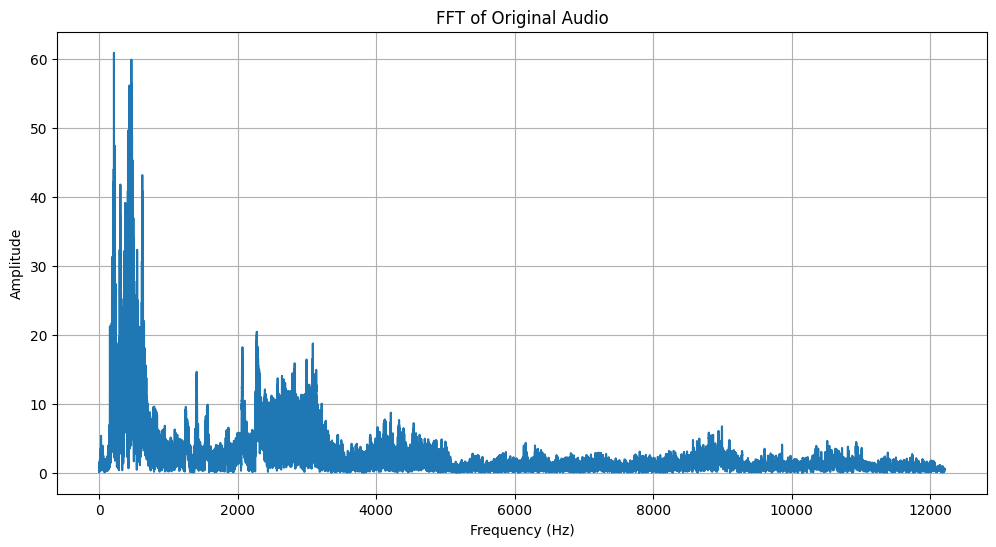

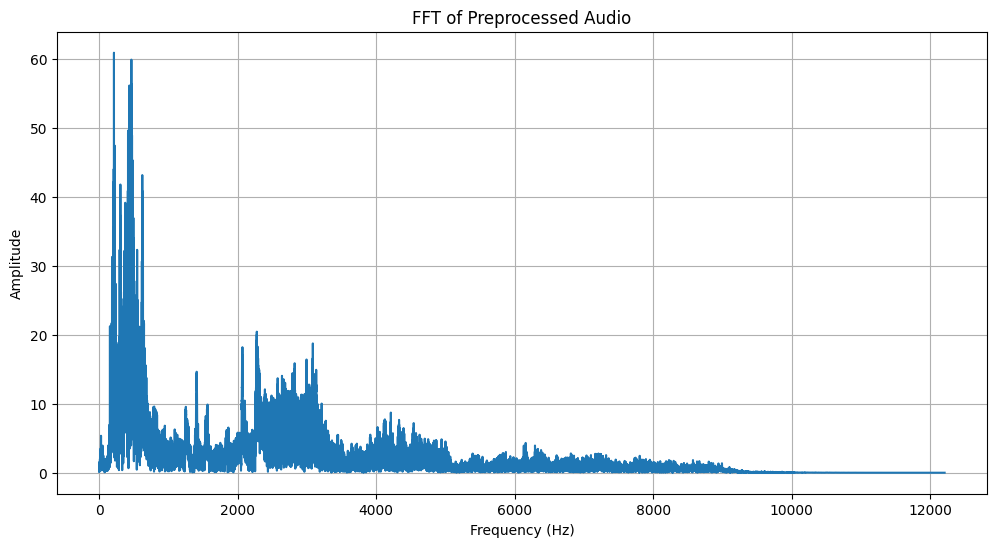

In [37]:
def plot_fft(audio_data, sr, title):
    """
    Plots the FFT of the given audio data.

    Parameters:
        audio_data (np.ndarray): Audio signal.
        sr (int): Sampling rate.
        title (str): Title for the plot.
    """
    # Compute the FFT
    fft_values = np.fft.fft(audio_data)
    fft_freq = np.fft.fftfreq(len(fft_values), 1 / sr)

    # Plot the FFT
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freq[:len(fft_freq)//2], np.abs(fft_values)[:len(fft_values)//2])
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

def plot_audio_fft(df, row_index):
    """
    Plots the FFT of the original and preprocessed audio in the specified row of the dataframe.

    Parameters:
        df (pd.DataFrame): DataFrame containing audio data.
        row_index (int): Index of the row to plot.
    """
    # Extract the original and preprocessed audio data
    original_audio = df.at[row_index, "audio_data"]
    processed_audio = df.at[row_index, "processed_audio"]
    sr = df.at[row_index, "sr"]

    # Plot the FFT of the original audio
    plot_fft(original_audio, sr, "FFT of Original Audio")

    # Plot the FFT of the preprocessed audio
    plot_fft(processed_audio, sr, "FFT of Preprocessed Audio")

# Plot the FFT for the first row of the dataframe
plot_audio_fft(original_df, row_index)

## **Feature Extraction**

### **Prosodic Features**

#### **Extract Pitch Features**

Original Audio - Mean: 202.538236095242
Original Audio - Std: 37.76942504228858
Original Audio - Min: 152.4497023255762
Original Audio - Max: 299.66141537533633
Preprocessed Audio - Mean: 200.97101943216674
Preprocessed Audio - Std: 36.91534858101745
Preprocessed Audio - Min: 152.4497023255762
Preprocessed Audio - Max: 299.66141537533633


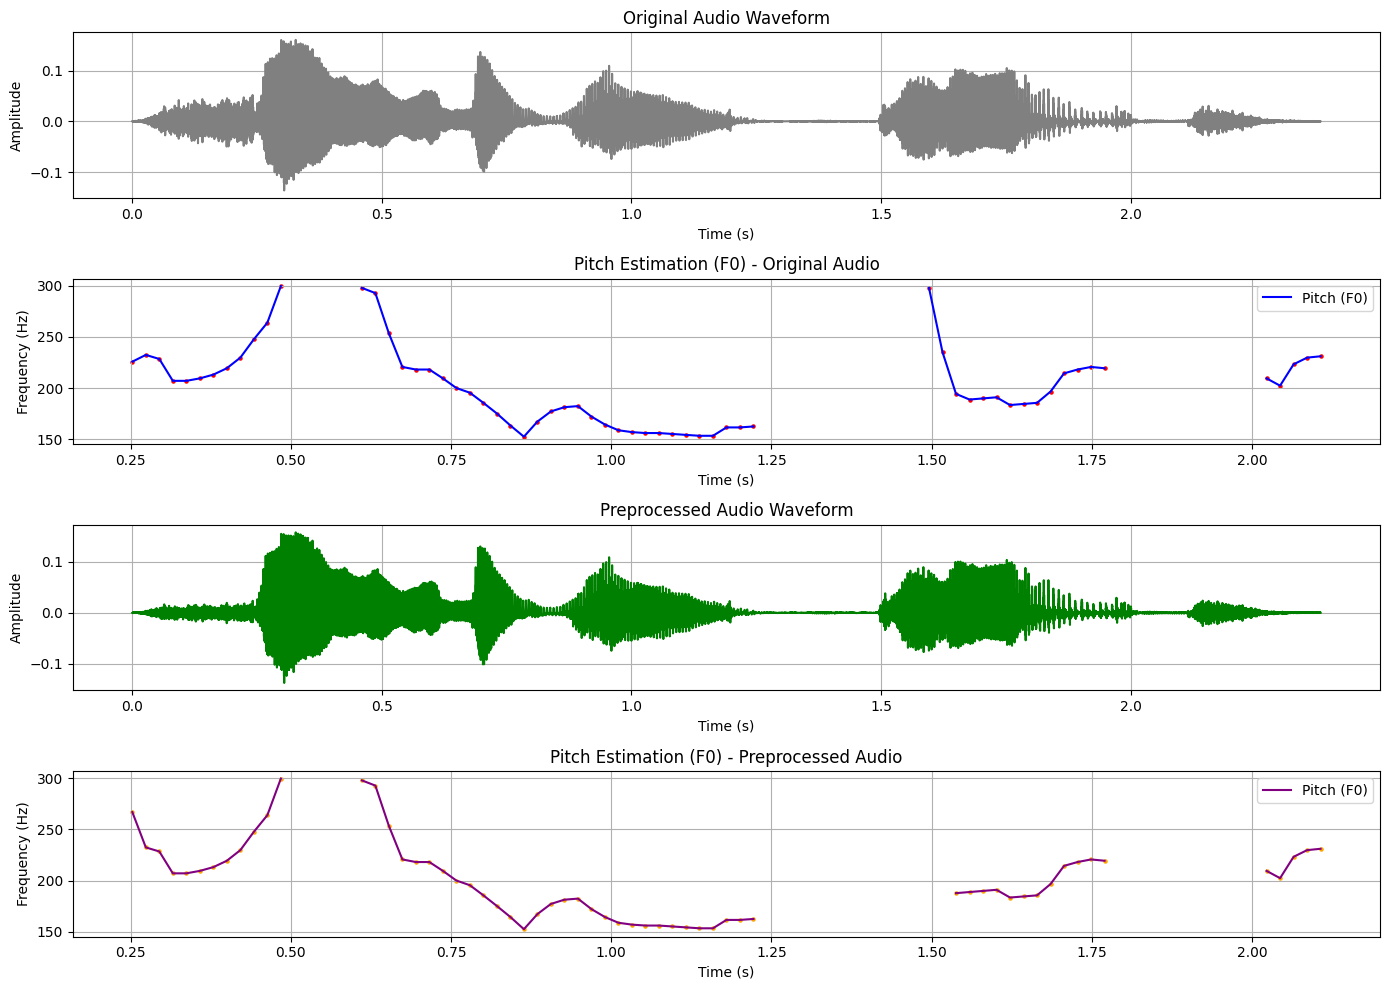

In [38]:
def extractNplot_pitch(original_audio, processed_audio, sr):
    """
    Extracts and visualizes the pitch (F0) of both the original and preprocessed audio signals.

    The function estimates the fundamental frequency (F0) using `librosa.pyin` for both
    the original and preprocessed audio. It computes basic statistics (mean, standard
    deviation, min, and max) for the cleaned pitch values (non-NaN). Additionally, it plots
    the audio waveform and the estimated pitch over time for both audio signals.

    Args:
        original_audio (np.ndarray): Original audio signal.
        processed_audio (np.ndarray): Preprocessed audio signal.
        sr (int): Sampling rate.

    Returns:
        None: This function does not return any values but visualizes the results
              and prints the computed statistics.
    """

    def analyze_pitch(y, sr, label):
        # Estimate the pitch (F0)
        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=50, fmax=300, sr=sr)

        # Remove NaN values (indicating pauses or unvoiced regions)
        f0_cleaned = f0[~np.isnan(f0)]

        # Statistics about the pitch
        pitch_mean = np.mean(f0_cleaned)
        pitch_std = np.std(f0_cleaned)
        pitch_min = np.min(f0_cleaned)
        pitch_max = np.max(f0_cleaned)

        print(f"{label} - Mean:", pitch_mean)
        print(f"{label} - Std:", pitch_std)
        print(f"{label} - Min:", pitch_min)
        print(f"{label} - Max:", pitch_max)

        # Generate time axis for the audio waveform
        time_audio = np.linspace(0, len(y) / sr, len(y))

        # Generate time axis for the estimated pitch (F0)
        time_pitch = np.linspace(0, len(y) / sr, len(f0))

        return f0, time_audio, time_pitch

    # Analyze original audio
    f0_original, time_audio_original, time_pitch_original = analyze_pitch(
        original_audio, sr, "Original Audio"
    )

    # Analyze processed audio
    f0_processed, time_audio_processed, time_pitch_processed = analyze_pitch(
        processed_audio, sr, "Preprocessed Audio"
    )

    # Plotting
    plt.figure(figsize=(14, 10))

    # Original Audio Waveform
    plt.subplot(4, 1, 1)
    plt.plot(time_audio_original, original_audio, color="gray")
    plt.title("Original Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Original Audio Pitch
    plt.subplot(4, 1, 2)
    plt.plot(time_pitch_original, f0_original, color="blue", label="Pitch (F0)")
    plt.scatter(
        time_pitch_original, f0_original, color="red", s=5
    )  # Markers at pitch points
    plt.title("Pitch Estimation (F0) - Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.grid(True)

    # Preprocessed Audio Waveform
    plt.subplot(4, 1, 3)
    plt.plot(time_audio_processed, processed_audio, color="green")
    plt.title("Preprocessed Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Preprocessed Audio Pitch
    plt.subplot(4, 1, 4)
    plt.plot(time_pitch_processed, f0_processed, color="purple", label="Pitch (F0)")
    plt.scatter(
        time_pitch_processed, f0_processed, color="orange", s=5
    )  # Markers at pitch points
    plt.title("Pitch Estimation (F0) - Preprocessed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Usage
audio_original, sr = original_df["audio_data"][row_index], original_df["sr"][row_index]
audio_processed = original_df["processed_audio"][row_index]
extractNplot_pitch(audio_original, audio_processed, sr)

#### **Extract Energy Features**

Original Audio - Energy (RMS):
Mean = 0.01609
Std  = 0.01305
Min  = 0.00020
Max  = 0.05226

Preprocessed Audio - Energy (RMS):
Mean = 0.01542
Std  = 0.01333
Min  = 0.00020
Max  = 0.05223



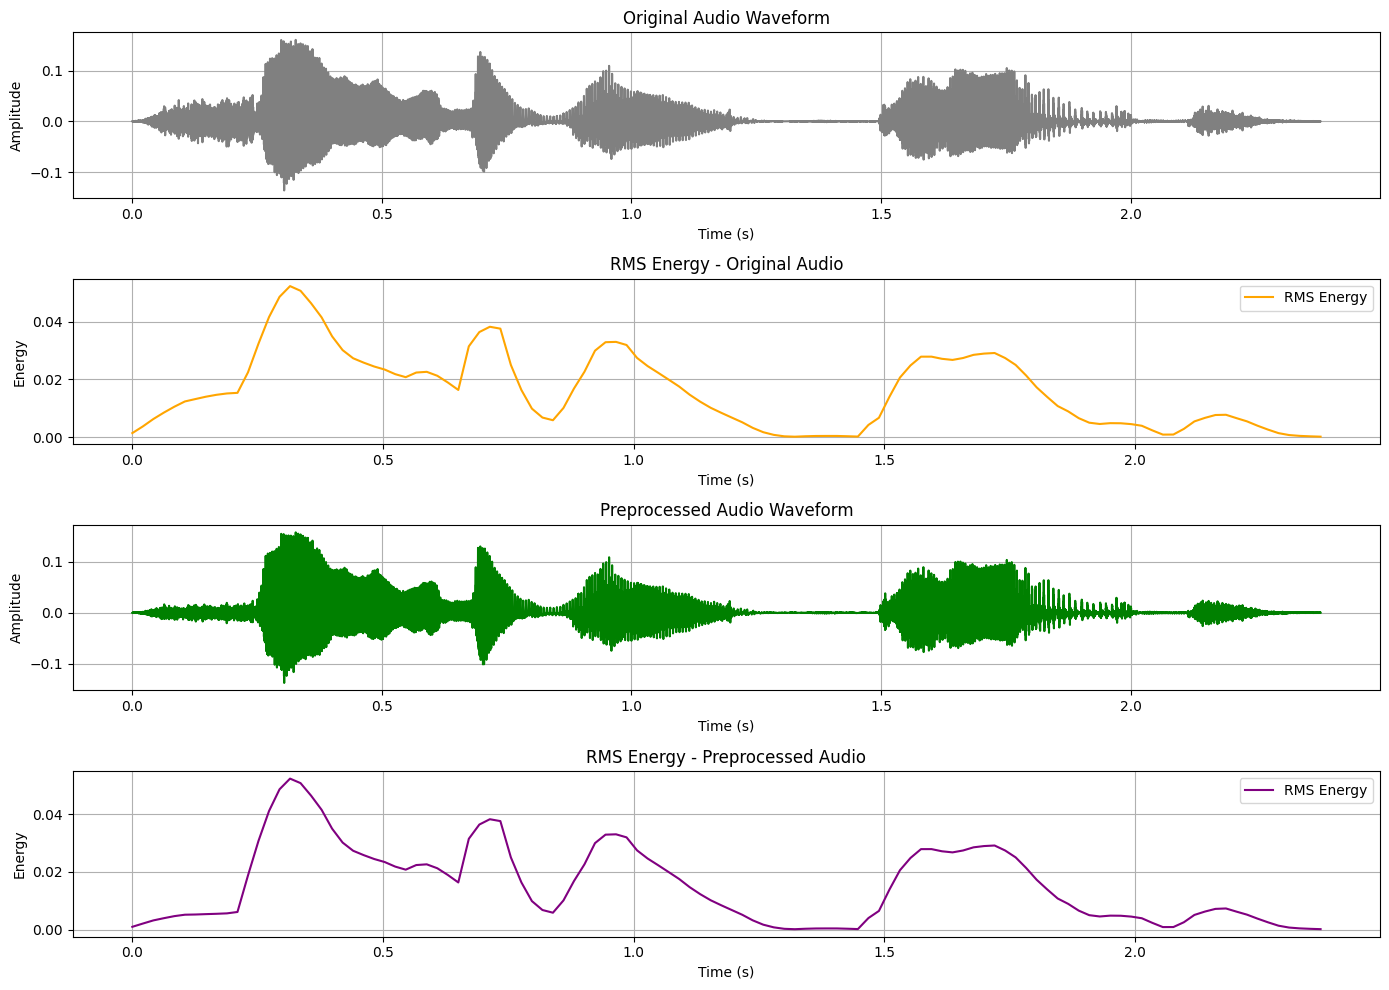

Energy Features: {'original_energy_stats': {'rms_mean': np.float32(0.016091885), 'rms_std': np.float32(0.013045471), 'rms_min': np.float32(0.00020072976), 'rms_max': np.float32(0.052260447)}, 'processed_energy_stats': {'rms_mean': np.float32(0.0154179), 'rms_std': np.float32(0.013329565), 'rms_min': np.float32(0.00019552665), 'rms_max': np.float32(0.052229237)}}


In [ ]:
def extractNplot_energy(original_audio, processed_audio, sr):
    """
    Extracts and visualizes the energy (RMS) of both the original and preprocessed audio signals.

    The function calculates the Root Mean Square (RMS) energy using `librosa.feature.rms` for both
    the original and preprocessed audio. It computes basic statistics (mean, standard deviation, min, and max)
    for the RMS values. Additionally, it plots the audio waveforms and their corresponding RMS energy over time.

    Args:
        original_audio (np.ndarray): Original audio signal.
        processed_audio (np.ndarray): Preprocessed audio signal.
        sr (int): Sampling rate.

    Returns:
        dict: A dictionary containing RMS statistics for both original and preprocessed audio.
    """

    def analyze_energy(y, sr, label):
        # Calculate the Root Mean Square (RMS) energy
        rms = librosa.feature.rms(y=y)[0]  # RMS values (energy)

        # Generate time values corresponding to each RMS frame
        times = librosa.times_like(rms, sr=sr)

        # Calculate energy statistics
        rms_mean = np.mean(rms)
        rms_std = np.std(rms)
        rms_min = np.min(rms)
        rms_max = np.max(rms)

        # Print the statistics
        print(f"{label} - Energy (RMS):")
        print(f"Mean = {rms_mean:.5f}")
        print(f"Std  = {rms_std:.5f}")
        print(f"Min  = {rms_min:.5f}")
        print(f"Max  = {rms_max:.5f}\n")

        return (
            rms,
            times,
            {
                "rms_mean": rms_mean,
                "rms_std": rms_std,
                "rms_min": rms_min,
                "rms_max": rms_max,
            },
        )

    # Analyze original audio
    rms_original, times_original, stats_original = analyze_energy(
        original_audio, sr, "Original Audio"
    )

    # Analyze preprocessed audio
    rms_processed, times_processed, stats_processed = analyze_energy(
        processed_audio, sr, "Preprocessed Audio"
    )

    # Plotting
    plt.figure(figsize=(14, 10))

    # Original Audio Waveform
    plt.subplot(4, 1, 1)
    plt.plot(
        np.linspace(0, len(original_audio) / sr, len(original_audio)),
        original_audio,
        color="gray",
    )
    plt.title("Original Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Original Audio RMS Energy
    plt.subplot(4, 1, 2)
    plt.plot(times_original, rms_original, label="RMS Energy", color="orange")
    plt.title("RMS Energy - Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy")
    plt.grid(True)
    plt.legend()

    # Preprocessed Audio Waveform
    plt.subplot(4, 1, 3)
    plt.plot(
        np.linspace(0, len(processed_audio) / sr, len(processed_audio)),
        processed_audio,
        color="green",
    )
    plt.title("Preprocessed Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Preprocessed Audio RMS Energy
    plt.subplot(4, 1, 4)
    plt.plot(times_processed, rms_processed, label="RMS Energy", color="purple")
    plt.title("RMS Energy - Preprocessed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        "original_energy_stats": stats_original,
        "processed_energy_stats": stats_processed,
    }


# Usage
# Ensure that the index [1999] exists in your DataFrame. Adjust the index as needed.
audio_original = original_df["audio_data"][row_index]
audio_processed = original_df["processed_audio"][row_index]
sr = original_df["sr"][row_index]

energy_features = extractNplot_energy(audio_original, audio_processed, sr)

#### **Extract Tempo Features**

Original Audio - Estimated Tempo: 98.66 BPM
Preprocessed Audio - Estimated Tempo: 98.66 BPM


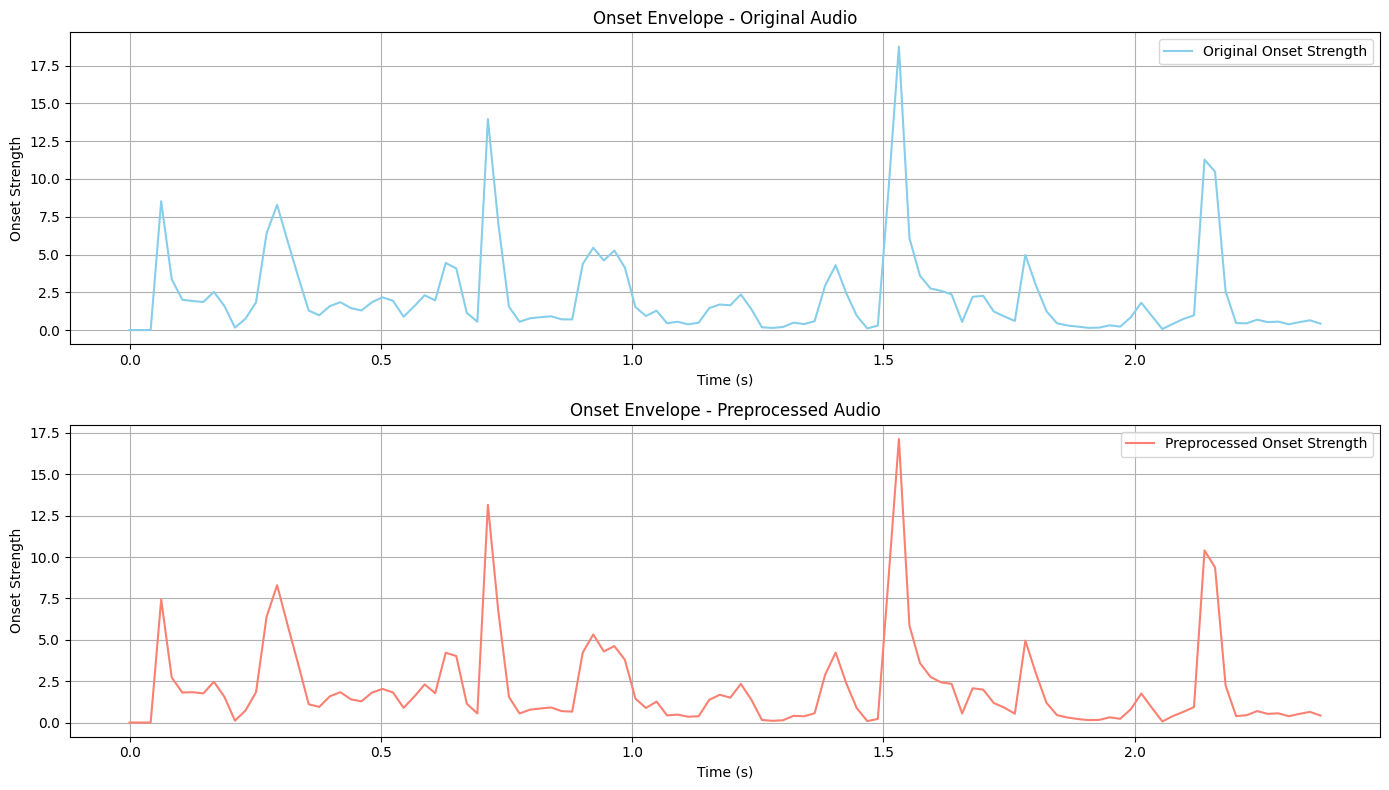

In [33]:
import numpy as np
import librosa
import matplotlib.pyplot as plt


def extractNplot_tempo(original_audio, processed_audio, sr):
    """
    Extracts and visualizes the tempo of both the original and preprocessed audio signals.

    The function calculates the tempo using `librosa.beat.beat_track` for both
    the original and preprocessed audio. It computes and prints the estimated tempo
    for each. Additionally, it plots the onset envelope for both audio signals.

    Args:
        original_audio (np.ndarray): Original audio signal.
        processed_audio (np.ndarray): Preprocessed audio signal.
        sr (int): Sampling rate.

    Returns:
        dict: A dictionary containing the estimated tempo for both audio signals.
    """

    def analyze_tempo(y, sr, label):
        # Calculate the onset envelope
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)

        # Estimate the tempo
        tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)

        # Print the tempo
        print(f"{label} - Estimated Tempo: {tempo[0]:.2f} BPM")

        # Generate time values for the onset envelope
        times = librosa.times_like(onset_env, sr=sr)

        return onset_env, times, tempo

    # Analyze original audio
    onset_original, times_original, tempo_original = analyze_tempo(
        original_audio, sr, "Original Audio"
    )

    # Analyze preprocessed audio
    onset_processed, times_processed, tempo_processed = analyze_tempo(
        processed_audio, sr, "Preprocessed Audio"
    )

    # Plotting
    plt.figure(figsize=(14, 8))

    # Original Audio Onset Envelope
    plt.subplot(2, 1, 1)
    plt.plot(
        times_original, onset_original, label="Original Onset Strength", color="skyblue"
    )
    plt.title("Onset Envelope - Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Onset Strength")
    plt.legend()
    plt.grid(True)

    # Preprocessed Audio Onset Envelope
    plt.subplot(2, 1, 2)
    plt.plot(
        times_processed,
        onset_processed,
        label="Preprocessed Onset Strength",
        color="salmon",
    )
    plt.title("Onset Envelope - Preprocessed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Onset Strength")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "original_tempo_bpm": tempo_original,
        "preprocessed_tempo_bpm": tempo_processed,
    }

audio_original = original_df["audio_data"][row_index]
audio_processed = original_df["processed_audio"][row_index]
sr = original_df["sr"][row_index]

tempo_features = extractNplot_tempo(audio_original, audio_processed, sr)

### **Spectral Features**

#### **Extract MFCC (Mel-Frequency Cepstral Coefficients) Features**

Original Audio - MFCC Statistics:
MFCC 1: Mean = -434.32422, Std = 124.70376
MFCC 2: Mean = 55.25143, Std = 80.18990
MFCC 3: Mean = 1.08558, Std = 37.23247
MFCC 4: Mean = 33.35920, Std = 42.62391
MFCC 5: Mean = -0.08125, Std = 20.27826
MFCC 6: Mean = -9.48700, Std = 32.96811
MFCC 7: Mean = -4.61407, Std = 14.69182
MFCC 8: Mean = -16.18826, Std = 22.83063
MFCC 9: Mean = -7.25628, Std = 11.59008
MFCC 10: Mean = -8.96303, Std = 17.15201
MFCC 11: Mean = -10.99509, Std = 12.40228
MFCC 12: Mean = 5.25935, Std = 10.50762
MFCC 13: Mean = -3.01487, Std = 13.22911


Preprocessed Audio - MFCC Statistics:
MFCC 1: Mean = -452.41522, Std = 117.08349
MFCC 2: Mean = 80.40278, Std = 71.64627
MFCC 3: Mean = -22.80398, Std = 40.93561
MFCC 4: Mean = 55.26305, Std = 43.23563
MFCC 5: Mean = -19.42341, Std = 25.62480
MFCC 6: Mean = 6.90514, Std = 32.21592
MFCC 7: Mean = -17.87088, Std = 21.41722
MFCC 8: Mean = -6.05809, Std = 26.41570
MFCC 9: Mean = -14.44036, Std = 15.26329
MFCC 10: Mean = -4.40903, Std = 1

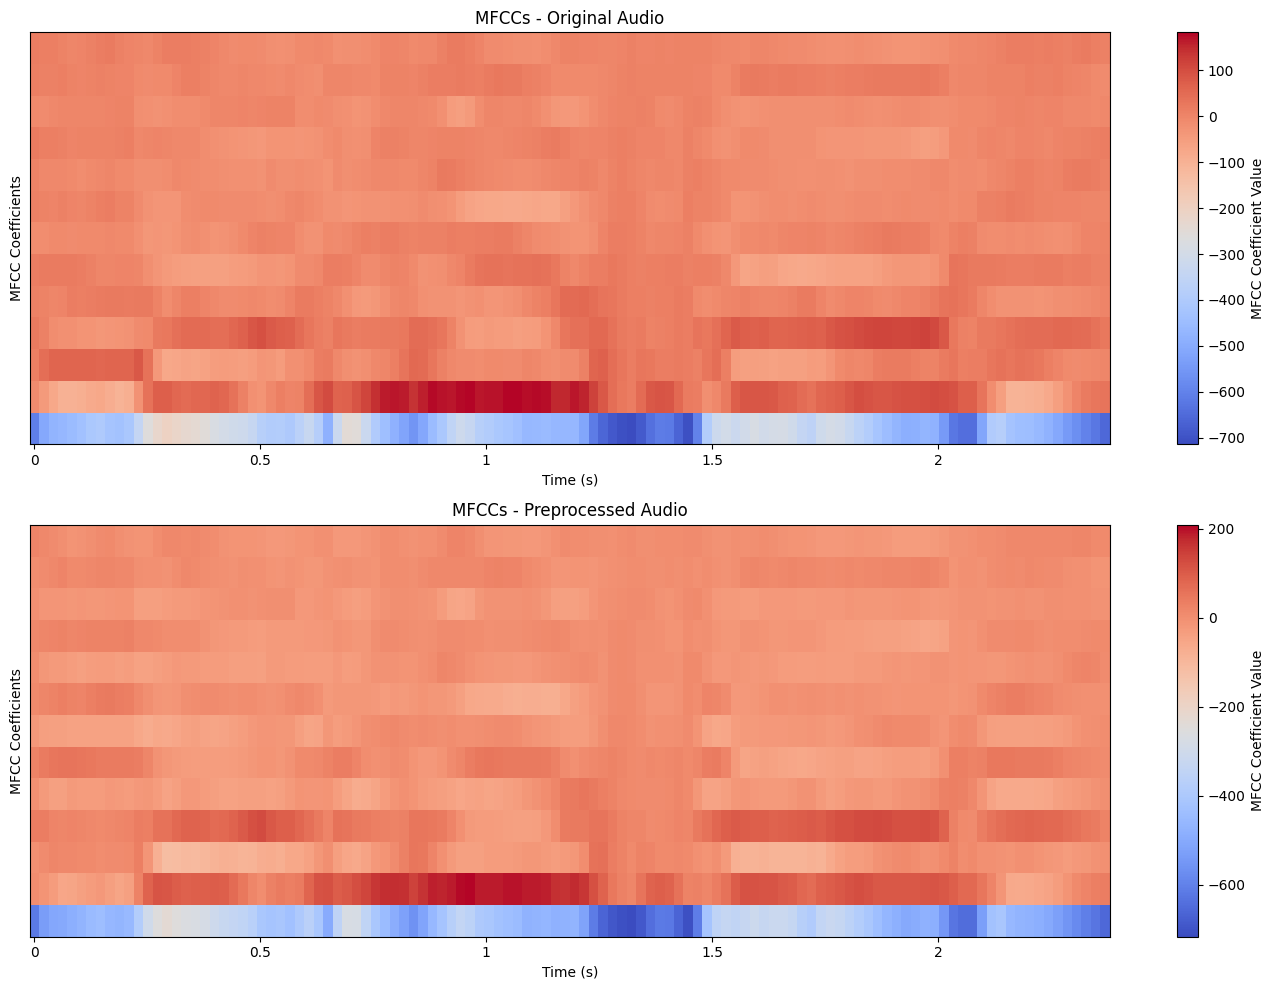

In [35]:
def extractNplot_mfcc(original_audio, processed_audio, sr):
    """
    Extracts and visualizes the MFCCs (Mel-Frequency Cepstral Coefficients) of both the original and preprocessed audio signals.
    Calculates key statistics such as mean and standard deviation for each MFCC coefficient.

    Args:
        original_audio (np.ndarray): Original audio signal.
        processed_audio (np.ndarray): Preprocessed audio signal.
        sr (int): Sampling rate.

    Returns:
        dict: A dictionary containing the mean and standard deviation of each MFCC coefficient for both audio signals.
    """

    def analyze_mfcc(y, sr, label, n_mfcc=13):
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Calculate the mean and standard deviation of each MFCC coefficient
        mfccs_mean = np.mean(mfccs, axis=1)  # Mean of each MFCC coefficient
        mfccs_std = np.std(mfccs, axis=1)  # Standard deviation of each MFCC coefficient

        # Print the statistics
        print(f"{label} - MFCC Statistics:")
        for i in range(n_mfcc):
            print(f"MFCC {i+1}: Mean = {mfccs_mean[i]:.5f}, Std = {mfccs_std[i]:.5f}")
        print("\n")

        # Generate time values for the MFCCs
        mfcc_times = librosa.times_like(mfccs, sr=sr)

        return mfccs, mfcc_times, {"mfccs_mean": mfccs_mean, "mfccs_std": mfccs_std}

    # Analyze original audio
    mfccs_original, times_original, stats_original = analyze_mfcc(
        original_audio, sr, "Original Audio"
    )

    # Analyze preprocessed audio
    mfccs_processed, times_processed, stats_processed = analyze_mfcc(
        processed_audio, sr, "Preprocessed Audio"
    )

    # Plotting
    plt.figure(figsize=(14, 10))

    # Original Audio MFCCs
    plt.subplot(2, 1, 1)
    librosa.display.specshow(mfccs_original, x_axis="time", sr=sr, cmap="coolwarm")
    plt.colorbar(label="MFCC Coefficient Value")
    plt.title("MFCCs - Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")

    # Preprocessed Audio MFCCs
    plt.subplot(2, 1, 2)
    librosa.display.specshow(mfccs_processed, x_axis="time", sr=sr, cmap="coolwarm")
    plt.colorbar(label="MFCC Coefficient Value")
    plt.title("MFCCs - Preprocessed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")

    plt.tight_layout()
    plt.show()

    return {
        "original_mfcc_stats": stats_original,
        "processed_mfcc_stats": stats_processed,
    }

audio_original = original_df["audio_data"][row_index]
audio_processed = original_df["processed_audio"][row_index]
sr = original_df["sr"][row_index]

mfcc_features = extractNplot_mfcc(audio_original, audio_processed, sr)

### **Extract Chroma Features**

Original Audio - Chroma Features Statistics:
Pitch Class 1: Mean = 0.30332, Std = 0.29799
Pitch Class 2: Mean = 0.30908, Std = 0.31125
Pitch Class 3: Mean = 0.29356, Std = 0.26399
Pitch Class 4: Mean = 0.35120, Std = 0.30888
Pitch Class 5: Mean = 0.36454, Std = 0.27879
Pitch Class 6: Mean = 0.41608, Std = 0.33724
Pitch Class 7: Mean = 0.41004, Std = 0.33517
Pitch Class 8: Mean = 0.39608, Std = 0.34799
Pitch Class 9: Mean = 0.33891, Std = 0.30992
Pitch Class 10: Mean = 0.36282, Std = 0.31504
Pitch Class 11: Mean = 0.38868, Std = 0.34104
Pitch Class 12: Mean = 0.35712, Std = 0.32784


Preprocessed Audio - Chroma Features Statistics:
Pitch Class 1: Mean = 0.31672, Std = 0.31203
Pitch Class 2: Mean = 0.25034, Std = 0.23497
Pitch Class 3: Mean = 0.24212, Std = 0.24418
Pitch Class 4: Mean = 0.31739, Std = 0.32065
Pitch Class 5: Mean = 0.31732, Std = 0.27196
Pitch Class 6: Mean = 0.37907, Std = 0.32932
Pitch Class 7: Mean = 0.40741, Std = 0.33428
Pitch Class 8: Mean = 0.41215, Std = 0.33233
P

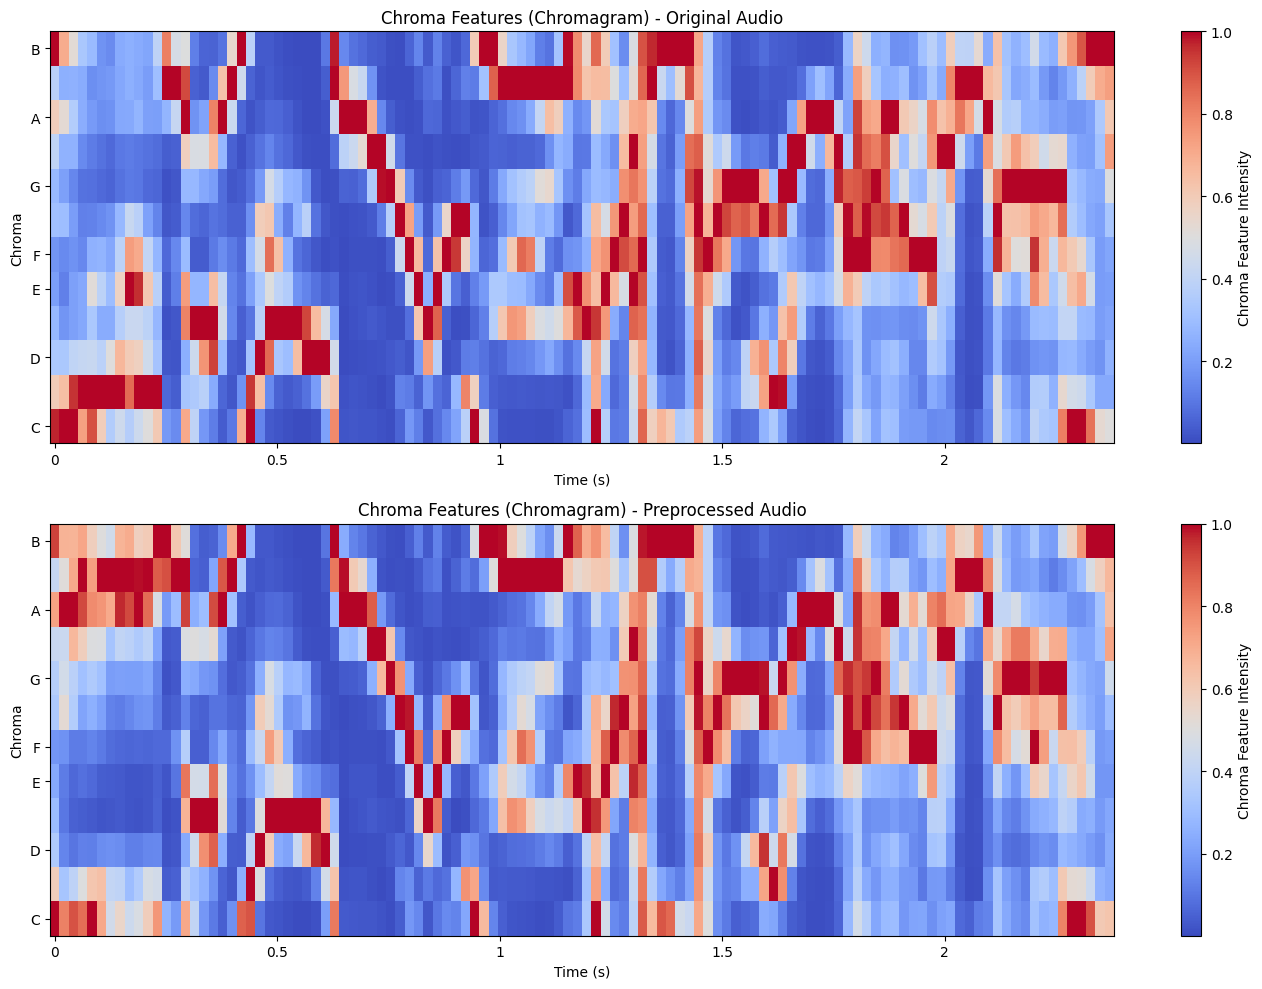

Chroma Features Statistics:
{'original_chroma_stats': {'chroma_mean': array([0.30331808, 0.30907643, 0.29355845, 0.35120204, 0.36453512,
       0.41608435, 0.41004008, 0.39608487, 0.33891383, 0.36282298,
       0.38868144, 0.35712197], dtype=float32), 'chroma_std': array([0.2979924 , 0.31124532, 0.2639938 , 0.30887872, 0.2787891 ,
       0.33724073, 0.33516878, 0.34799322, 0.30992383, 0.3150448 ,
       0.341044  , 0.3278427 ], dtype=float32)}, 'processed_chroma_stats': {'chroma_mean': array([0.31672257, 0.25033663, 0.24212376, 0.31738873, 0.31732031,
       0.37906987, 0.40740753, 0.41215455, 0.36872699, 0.41789802,
       0.44216751, 0.40351996]), 'chroma_std': array([0.31203092, 0.23496906, 0.24417897, 0.32065379, 0.27195899,
       0.32931628, 0.33428089, 0.33232787, 0.30281216, 0.35652313,
       0.36192621, 0.34684933])}}


In [ ]:
def extractNplot_chroma(original_audio, processed_audio, sr):
    """
    Extracts and visualizes the Chroma Features (chromagram) of both the original and preprocessed audio signals.
    Calculates key statistics such as mean and standard deviation for each pitch class.

    Args:
        original_audio (np.ndarray): Original audio signal.
        processed_audio (np.ndarray): Preprocessed audio signal.
        sr (int): Sampling rate.

    Returns:
        dict: A dictionary containing the mean and standard deviation of each Chroma feature for both audio signals.
    """

    def analyze_chroma(y, sr, label, n_chroma=12):
        """
        Extracts Chroma features, calculates statistics, and prints them.

        Args:
            y (np.ndarray): Audio signal.
            sr (int): Sampling rate.
            label (str): Label to distinguish between original and preprocessed audio.
            n_chroma (int, optional): Number of chroma features. Default is 12.

        Returns:
            tuple: chroma_features, times, statistics
        """
        # Extract the Chroma Features (chromagram) from the audio signal
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)

        # Calculate the mean and standard deviation for each pitch class (12 bins)
        chroma_mean = np.mean(
            chroma, axis=1
        )  # Mean of each chroma feature (pitch class)
        chroma_std = np.std(
            chroma, axis=1
        )  # Standard deviation of each chroma feature (pitch class)

        # Print the statistics
        print(f"{label} - Chroma Features Statistics:")
        for i in range(n_chroma):
            print(
                f"Pitch Class {i+1}: Mean = {chroma_mean[i]:.5f}, Std = {chroma_std[i]:.5f}"
            )
        print("\n")

        # Generate time values for the chromagram
        chroma_times = librosa.times_like(chroma, sr=sr)

        return (
            chroma,
            chroma_times,
            {"chroma_mean": chroma_mean, "chroma_std": chroma_std},
        )

    # Analyze original audio
    chroma_original, times_original, stats_original = analyze_chroma(
        original_audio, sr, "Original Audio"
    )

    # Analyze preprocessed audio
    chroma_processed, times_processed, stats_processed = analyze_chroma(
        processed_audio, sr, "Preprocessed Audio"
    )

    # Plotting
    plt.figure(figsize=(14, 10))

    # Original Audio Chromagram
    plt.subplot(2, 1, 1)
    librosa.display.specshow(
        chroma_original, x_axis="time", y_axis="chroma", sr=sr, cmap="coolwarm"
    )
    plt.colorbar(label="Chroma Feature Intensity")
    plt.title("Chroma Features (Chromagram) - Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Chroma")
    plt.tight_layout()

    # Preprocessed Audio Chromagram
    plt.subplot(2, 1, 2)
    librosa.display.specshow(
        chroma_processed, x_axis="time", y_axis="chroma", sr=sr, cmap="coolwarm"
    )
    plt.colorbar(label="Chroma Feature Intensity")
    plt.title("Chroma Features (Chromagram) - Preprocessed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Chroma")
    plt.tight_layout()

    plt.show()

    return {
        "original_chroma_stats": stats_original,
        "processed_chroma_stats": stats_processed,
    }

audio_original = original_df["audio_data"][row_index]
audio_processed = original_df["processed_audio"][row_index]
sr = original_df["sr"][row_index]

chroma_features = extractNplot_chroma(audio_original, audio_processed, sr)

#### **Extract Spectral Centroid**

Original Audio - Spectral Centroid Statistics:
Mean = 3432.97 Hz
Std  = 2246.90 Hz

Preprocessed Audio - Spectral Centroid Statistics:
Mean = 2815.15 Hz
Std  = 1768.35 Hz



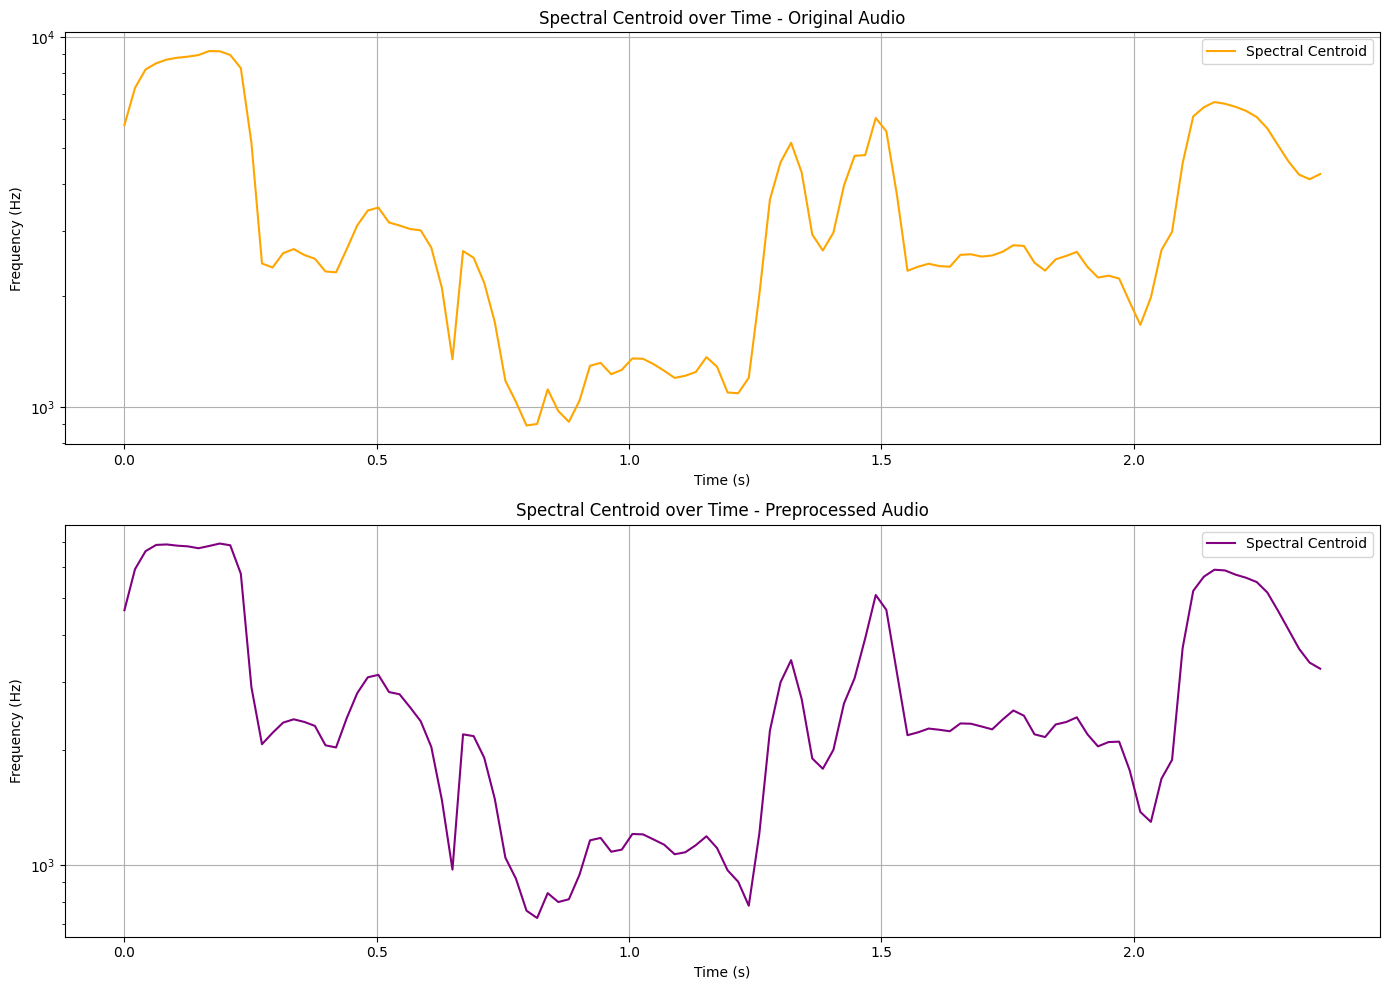

In [40]:
def extractNplot_spectral_centroid(original_audio, processed_audio, sr):
    """
    Extracts and visualizes the Spectral Centroid of both the original and preprocessed audio signals.
    Calculates key statistics such as mean and standard deviation.

    Args:
        original_audio (np.ndarray): Original audio signal.
        processed_audio (np.ndarray): Preprocessed audio signal.
        sr (int): Sampling rate.

    Returns:
        dict: A dictionary containing the mean and standard deviation of the Spectral Centroid for both audio signals.
    """

    def analyze_spectral_centroid(y, sr, label):
        """
        Extracts spectral centroid, calculates statistics, and prints them.

        Args:
            y (np.ndarray): Audio signal.
            sr (int): Sampling rate.
            label (str): Label to distinguish between original and preprocessed audio.

        Returns:
            tuple: spectral_centroid, times, statistics
        """
        # Extract the Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

        # Calculate the mean and standard deviation of the Spectral Centroid
        centroid_mean = np.mean(spectral_centroid)
        centroid_std = np.std(spectral_centroid)

        # Print the statistics
        print(f"{label} - Spectral Centroid Statistics:")
        print(f"Mean = {centroid_mean:.2f} Hz")
        print(f"Std  = {centroid_std:.2f} Hz\n")

        # Generate time values for the Spectral Centroid
        times = librosa.times_like(spectral_centroid, sr=sr)

        return (
            spectral_centroid,
            times,
            {
                "centroid_mean": centroid_mean,
                "centroid_std": centroid_std,
            },
        )

    # Analyze original audio
    spectral_original, times_original, stats_original = analyze_spectral_centroid(
        original_audio, sr, "Original Audio"
    )

    # Analyze preprocessed audio
    spectral_processed, times_processed, stats_processed = analyze_spectral_centroid(
        processed_audio, sr, "Preprocessed Audio"
    )

    # Plotting
    plt.figure(figsize=(14, 10))

    # Original Audio Spectral Centroid
    plt.subplot(2, 1, 1)
    plt.semilogy(
        times_original, spectral_original, label="Spectral Centroid", color="orange"
    )
    plt.title("Spectral Centroid over Time - Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.grid(True)

    # Preprocessed Audio Spectral Centroid
    plt.subplot(2, 1, 2)
    plt.semilogy(
        times_processed, spectral_processed, label="Spectral Centroid", color="purple"
    )
    plt.title("Spectral Centroid over Time - Preprocessed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "original_spectral_centroid_stats": stats_original,
        "processed_spectral_centroid_stats": stats_processed,
    }

audio_original = original_df["audio_data"][row_index]
audio_processed = original_df["processed_audio"][row_index]
sr = original_df["sr"][row_index]

spectral_centroid_stats = extractNplot_spectral_centroid(
    audio_original, audio_processed, sr
)

#### **Extract Spectral Bandwith**

Original Audio - Spectral Bandwidth Statistics:
Mean = 2373.86 Hz
Std  = 635.29 Hz

Preprocessed Audio - Spectral Bandwidth Statistics:
Mean = 1811.24 Hz
Std  = 465.85 Hz



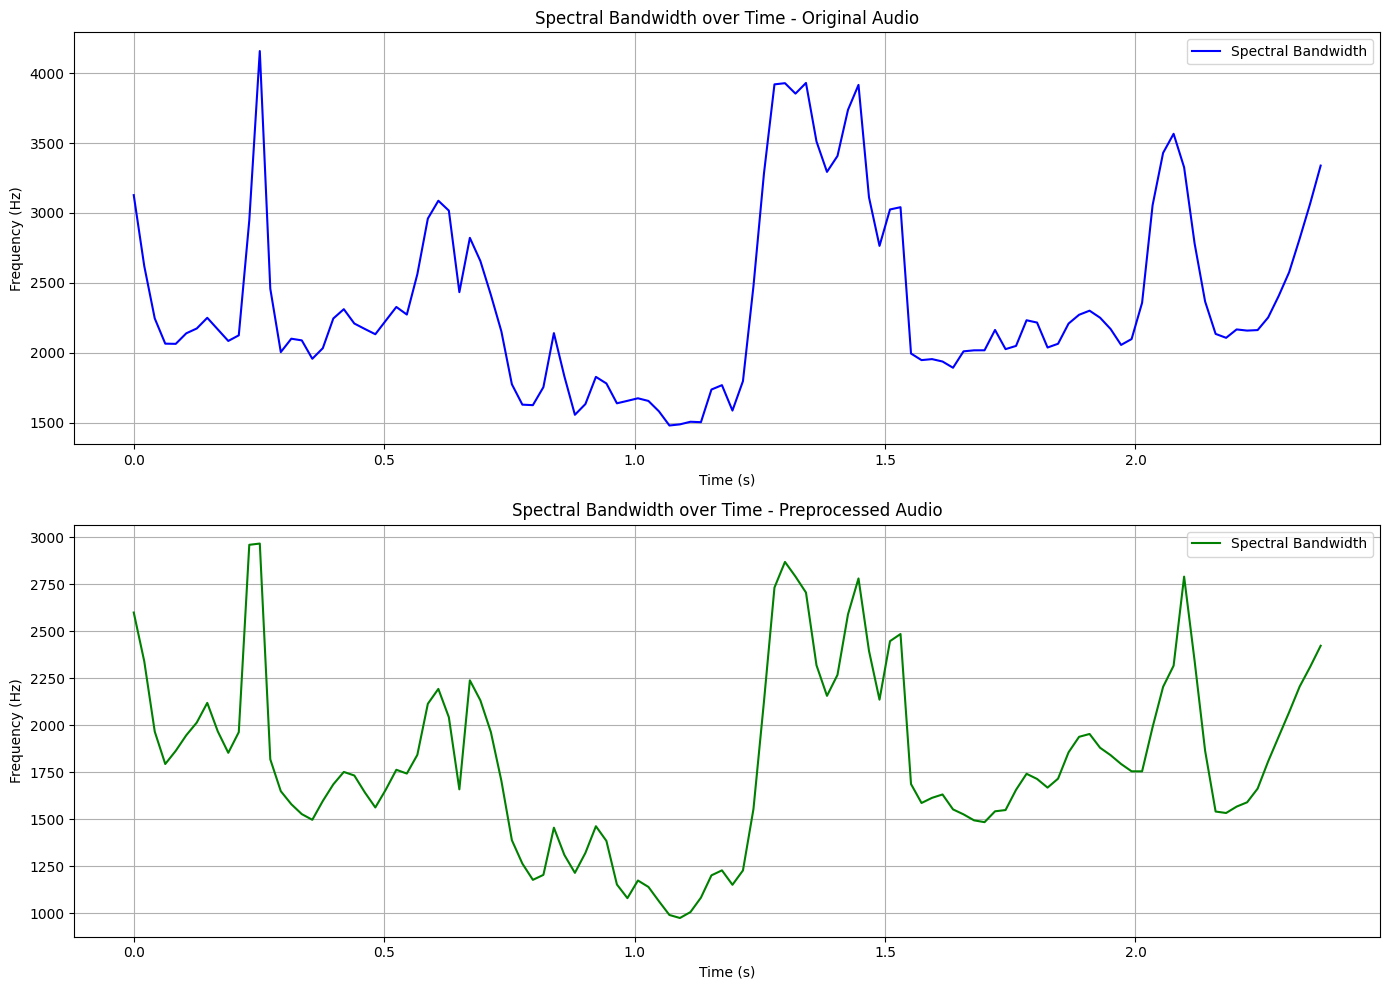

In [41]:
def extractNplot_spectral_bandwidth(original_audio, processed_audio, sr):
    """
    Extracts and visualizes the Spectral Bandwidth of both the original and preprocessed audio signals.
    Calculates key statistics such as mean and standard deviation.

    Args:
        original_audio (np.ndarray): Original audio signal.
        processed_audio (np.ndarray): Preprocessed audio signal.
        sr (int): Sampling rate.

    Returns:
        dict: A dictionary containing the mean and standard deviation of the Spectral Bandwidth for both audio signals.
    """

    def analyze_spectral_bandwidth(y, sr, label):
        """
        Extracts spectral bandwidth, calculates statistics, and prints them.

        Args:
            y (np.ndarray): Audio signal.
            sr (int): Sampling rate.
            label (str): Label to distinguish between original and preprocessed audio.

        Returns:
            tuple: spectral_bandwidth, times, statistics
        """
        # Extract the Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

        # Calculate the mean and standard deviation of the Spectral Bandwidth
        bandwidth_mean = np.mean(spectral_bandwidth)
        bandwidth_std = np.std(spectral_bandwidth)

        # Print the statistics
        print(f"{label} - Spectral Bandwidth Statistics:")
        print(f"Mean = {bandwidth_mean:.2f} Hz")
        print(f"Std  = {bandwidth_std:.2f} Hz\n")

        # Generate time values for the Spectral Bandwidth
        times = librosa.times_like(spectral_bandwidth, sr=sr)

        return (
            spectral_bandwidth,
            times,
            {
                "bandwidth_mean": bandwidth_mean,
                "bandwidth_std": bandwidth_std,
            },
        )

    # Analyze original audio
    spectral_original, times_original, stats_original = analyze_spectral_bandwidth(
        original_audio, sr, "Original Audio"
    )

    # Analyze preprocessed audio
    spectral_processed, times_processed, stats_processed = analyze_spectral_bandwidth(
        processed_audio, sr, "Preprocessed Audio"
    )

    # Plotting
    plt.figure(figsize=(14, 10))

    # Original Audio Spectral Bandwidth
    plt.subplot(2, 1, 1)
    plt.plot(
        times_original, spectral_original, label="Spectral Bandwidth", color="blue"
    )
    plt.title("Spectral Bandwidth over Time - Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.grid(True)

    # Preprocessed Audio Spectral Bandwidth
    plt.subplot(2, 1, 2)
    plt.plot(
        times_processed, spectral_processed, label="Spectral Bandwidth", color="green"
    )
    plt.title("Spectral Bandwidth over Time - Preprocessed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "original_spectral_bandwidth_stats": stats_original,
        "processed_spectral_bandwidth_stats": stats_processed,
    }

audio_original = original_df["audio_data"][row_index]
audio_processed = original_df["processed_audio"][row_index]
sr = original_df["sr"][row_index]

spectral_bandwidth_stats = extractNplot_spectral_bandwidth(
    audio_original, audio_processed, sr
)

#### **Extract Spectral Flux**

Original Audio - Spectral Flux Statistics:
Mean = 2.25
Std  = 2.94

Preprocessed Audio - Spectral Flux Statistics:
Mean = 2.14
Std  = 2.74



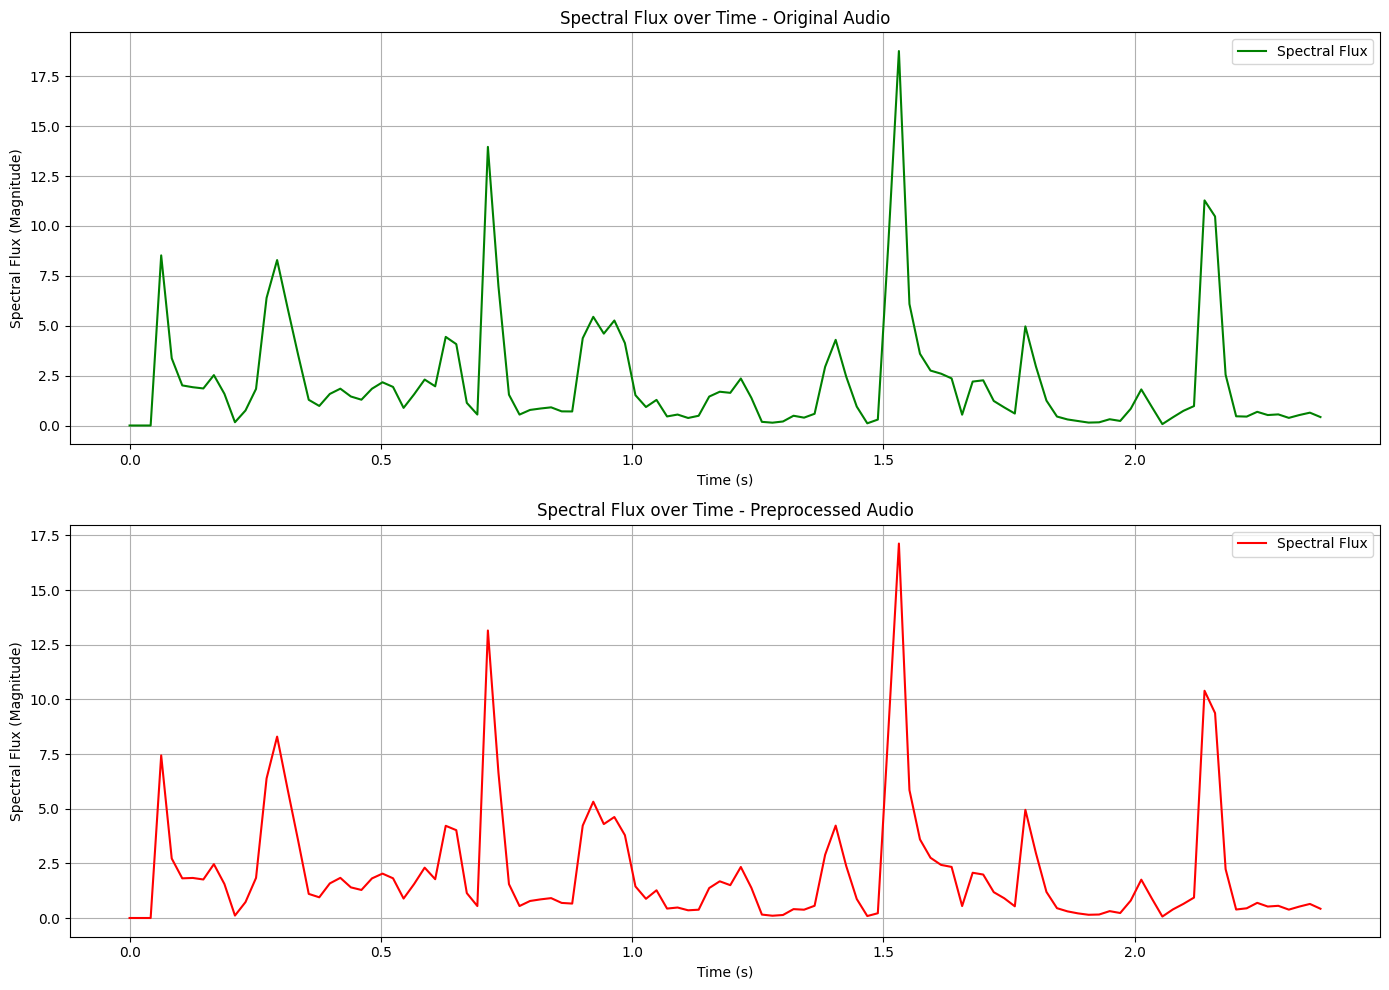

In [42]:
def extractNplot_spectral_flux(original_audio, processed_audio, sr):
    """
    Extracts and visualizes the Spectral Flux of both the original and preprocessed audio signals.
    Calculates key statistics such as mean and standard deviation.

    Args:
        original_audio (np.ndarray): Original audio signal.
        processed_audio (np.ndarray): Preprocessed audio signal.
        sr (int): Sampling rate.

    Returns:
        dict: A dictionary containing the mean and standard deviation of the Spectral Flux for both audio signals.
    """

    def analyze_spectral_flux(y, sr, label):
        """
        Extracts spectral flux, calculates statistics, and prints them.

        Args:
            y (np.ndarray): Audio signal.
            sr (int): Sampling rate.
            label (str): Label to distinguish between original and preprocessed audio.

        Returns:
            tuple: spectral_flux, times, statistics
        """
        # Extract the Spectral Flux
        spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)

        # Calculate the mean and standard deviation of the Spectral Flux
        flux_mean = np.mean(spectral_flux)
        flux_std = np.std(spectral_flux)

        # Print the statistics
        print(f"{label} - Spectral Flux Statistics:")
        print(f"Mean = {flux_mean:.2f}")
        print(f"Std  = {flux_std:.2f}\n")

        # Generate time values for the Spectral Flux
        times = librosa.times_like(spectral_flux, sr=sr)

        return (
            spectral_flux,
            times,
            {
                "flux_mean": flux_mean,
                "flux_std": flux_std,
            },
        )

    # Analyze original audio
    spectral_original, times_original, stats_original = analyze_spectral_flux(
        original_audio, sr, "Original Audio"
    )

    # Analyze preprocessed audio
    spectral_processed, times_processed, stats_processed = analyze_spectral_flux(
        processed_audio, sr, "Preprocessed Audio"
    )

    # Plotting
    plt.figure(figsize=(14, 10))

    # Original Audio Spectral Flux
    plt.subplot(2, 1, 1)
    plt.plot(times_original, spectral_original, label="Spectral Flux", color="green")
    plt.title("Spectral Flux over Time - Original Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Spectral Flux (Magnitude)")
    plt.legend()
    plt.grid(True)

    # Preprocessed Audio Spectral Flux
    plt.subplot(2, 1, 2)
    plt.plot(times_processed, spectral_processed, label="Spectral Flux", color="red")
    plt.title("Spectral Flux over Time - Preprocessed Audio")
    plt.xlabel("Time (s)")
    plt.ylabel("Spectral Flux (Magnitude)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "original_spectral_flux_stats": stats_original,
        "processed_spectral_flux_stats": stats_processed,
    }

audio_original = original_df["audio_data"][row_index]
audio_processed = original_df["processed_audio"][row_index]
sr = original_df["sr"][row_index]

spectral_flux_stats = extractNplot_spectral_flux(audio_original, audio_processed, sr)

## **Building Features Dataframe**

### **Feature Extraction Functions**

#### **Prosodic Features**

In [14]:
def extract_pitch(audio_data, sr):
    pitches, magnitudes = librosa.piptrack(y=audio_data, sr=sr)
    pitch = [p[m.argmax()] for p, m in zip(pitches, magnitudes) if m.max() > 0]

    if pitch:
        pitch_mean = np.mean(pitch)
        pitch_std = np.std(pitch)
    else:
        pitch_mean = np.nan
        pitch_std = np.nan

    return np.array([pitch_mean, pitch_std])


def extract_energy(audio_data):
    rms = librosa.feature.rms(y=audio_data)[0]
    energy_mean = np.mean(rms)
    energy_std = np.std(rms)
    return np.array([energy_mean, energy_std])

def extract_tempo(audio_data, sr):
    tempo, _ = librosa.beat.beat_track(y=audio_data, sr=sr)
    return np.array([tempo])

#### **Spectral Features**

In [15]:
def extract_mfcc(audio_data, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    return np.concatenate([mfccs_mean, mfccs_std])


def extract_chroma(audio_data, sr):
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    return np.concatenate([chroma_mean, chroma_std])


def extract_spectral_centroid(audio_data, sr):
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_std = np.std(spectral_centroid)
    return np.array([spectral_centroid_mean, spectral_centroid_std])


def extract_spectral_bandwidth(audio_data, sr):
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    spectral_bandwidth_std = np.std(spectral_bandwidth)
    return np.array([spectral_bandwidth_mean, spectral_bandwidth_std])


def extract_spectral_flux(audio_data, sr):
    spectral_flux = np.mean(
        np.diff(librosa.feature.spectral_centroid(y=audio_data, sr=sr), axis=1)
    )
    return np.array([spectral_flux])

In [43]:
def extract_features_combined(y, sr):
    features = {}

    # Prosodic Features
    # Extract and aggregate Pitch
    pitch = extract_pitch(y, sr)
    features["pitch_mean"] = pitch[0]
    features["pitch_std"] = pitch[1]

    # Extract and aggregate Energy
    energy = extract_energy(y)
    features["energy_mean"] = energy[0]
    features["energy_std"] = energy[1]
    
    # Extract Tempo
    tempo = extract_tempo(y, sr)
    features["tempo"] = tempo[0]

    # Spectral Features
    # Extract and aggregate MFCCs
    mfccs = extract_mfcc(y, sr)
    for i in range(1, 14):
        features[f"mfcc_{i}_mean"] = mfccs[i - 1]
    for i in range(14, 27):
        features[f"mfcc_{i-13}_std"] = mfccs[i - 1]

    # Extract and aggregate Chroma
    chroma = extract_chroma(y, sr)
    for i in range(1, 13):
        features[f"chroma_{i}_mean"] = chroma[i - 1]
    for i in range(13, 25):
        features[f"chroma_{i-12}_std"] = chroma[i - 1]

    # Extract and aggregate Spectral Centroid
    spectral_centroid = extract_spectral_centroid(y, sr)
    features["spectral_centroid_mean"] = spectral_centroid[0]
    features["spectral_centroid_std"] = spectral_centroid[1]

    # Extract and aggregate Spectral Bandwidth
    spectral_bandwidth = extract_spectral_bandwidth(y, sr)
    features["spectral_bandwidth_mean"] = spectral_bandwidth[0]
    features["spectral_bandwidth_std"] = spectral_bandwidth[1]

    # Extract Spectral Flux
    spectral_flux = extract_spectral_flux(y, sr)
    features["spectral_flux"] = spectral_flux[0]

    return features


def create_feature_dataframe(df, audio_column, sr_column):
    """
    Extract features from audio data and create a feature dataframe.

    Parameters:
    - df (pd.DataFrame): DataFrame containing audio data.
    - audio_column (str): Name of the column with audio time series.
    - sr_column (str): Name of the column with sampling rates.

    Returns:
    - pd.DataFrame: DataFrame with extracted features.
    """
    feature_list = []

    for index in tqdm(df.index, desc="Extracting Features from Audios"):
        y = df.at[index, audio_column]
        sr = df.at[index, sr_column]

        # Ensure audio data is valid
        if isinstance(y, (np.ndarray, list)) and len(y) > 0:
            features = extract_features_combined(y, sr)
        else:
            # Handle invalid data by setting features to NaN
            features = {
                **{f"mfcc_{i}_mean": np.nan for i in range(1, 14)},
                **{f"mfcc_{i}_std": np.nan for i in range(1, 14)},
                **{f"chroma_{i}_mean": np.nan for i in range(1, 13)},
                **{f"chroma_{i}_std": np.nan for i in range(1, 13)},
                "spectral_centroid_mean": np.nan,
                "spectral_centroid_std": np.nan,
                "spectral_bandwidth_mean": np.nan,
                "spectral_bandwidth_std": np.nan,
                "spectral_flux": np.nan,
                "pitch_mean": np.nan,
                "pitch_std": np.nan,
                "energy_mean": np.nan,
                "energy_std": np.nan,
            }

        feature_list.append(features)

    features_df = pd.DataFrame(feature_list)
    return features_df

#### **Create Features Dataframe**

In [17]:
features_df = create_feature_dataframe(original_df, "processed_audio", "sr")
features_df.shape

Extracting Features from Audios: 100%|██████████| 2000/2000 [02:56<00:00, 11.33it/s]


(2000, 60)

#### **Concatenate Features Dataframes to the Main Dataframe**

In [18]:
# add the extracted features to the original dataframe
df = pd.concat([original_df, features_df], axis=1)
df.head()

,filename,emotion,audio_data,sr,processed_audio,pitch_mean,pitch_std,energy_mean,energy_std,tempo,...,chroma_8_std,chroma_9_std,chroma_10_std,chroma_11_std,chroma_12_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_flux
0,YAF_date_disgust.wav,disgust,"[9.1552734e-05, 0.00018310547, 9.1552734e-05, ...",24414,"[1.4131668638963527e-05, 7.726086637492298e-05...",2070.591568,1120.469008,0.015418,0.013330,[98.65571120689656],...,0.332328,0.302812,0.356523,0.361926,0.346849,2815.153939,1768.353238,1811.240682,465.852653,-12.179462
1,YAF_rag_disgust.wav,disgust,"[0.0, 0.00015258789, 0.0, 0.0, -3.0517578e-05,...",24414,"[0.0, 2.355278106493921e-05, 8.166254849499323...",2037.087564,1102.112120,0.022623,0.017911,[98.65571120689656],...,0.307280,0.345567,0.353331,0.345808,0.337008,2317.874335,1696.973793,1694.602748,468.787054,-11.435359
2,YAF_raise_disgust.wav,disgust,"[6.1035156e-05, 0.0, 6.1035156e-05, 0.00024414...",24414,"[9.421112425975685e-06, 3.2665019397997294e-05...",1996.430926,1114.189422,0.020351,0.017920,[168.29503676470588],...,0.329116,0.334747,0.371361,0.356648,0.371853,2720.120778,2114.259655,1768.740747,534.521182,-18.040297
3,YAF_ditch_disgust.wav,disgust,"[0.00021362305, 0.00045776367, 0.00021362305, ...",24414,"[3.297389349091489e-05, 0.00018498591108780815...",2101.673637,1120.330242,0.015107,0.013180,[102.17912946428571],...,0.326943,0.313534,0.356622,0.309197,0.357699,2841.081737,1742.598593,1801.236721,488.208687,-8.470522
4,YAF_door_disgust.wav,disgust,"[-0.00024414062, -0.00039672852, -6.1035156e-0...",24414,"[-3.768444970390274e-05, -0.000191897308360831...",1820.374058,1108.535342,0.026547,0.026358,[73.359375],...,0.333432,0.327187,0.342298,0.368331,0.368957,2240.407670,1896.442733,1689.637228,636.490745,-21.101539


### **Supervised Algorithms**

In [19]:
def run_knn_classification(X_train, X_test, y_train, y_test):
    # Initialize the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5)

    # Train the model
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    print("------------------- K-Nearest Neighbors -------------------\n")

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    class_report = classification_report(y_test, y_pred)

    print("Classification Report:")
    print(class_report)


def run_random_forest_classification(X_train, X_test, y_train, y_test):
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=99)

    # Train the model
    rf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf.predict(X_test)

    print("------------------- Random Forest -------------------\n")

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    class_report = classification_report(y_test, y_pred)

    print("Classification Report:")
    print(class_report)

#### **Split Data**

In [44]:
# Split the data into features and labels
X = df.drop(columns=["filename", "emotion", "audio_data", "processed_audio", "sr"])
y = df["emotion"]

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets using the 70-30 holdout method
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=99,
)

#### **Run K-Neighbors Classifier**

In [46]:
run_knn_classification(X_train, X_test, y_train, y_test)

------------------- K-Nearest Neighbors -------------------

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

       angry       0.99      0.98      0.98       122
     disgust       0.98      0.95      0.97       119
        fear       0.98      0.98      0.98       120
       happy       0.95      0.99      0.97       126
         sad       1.00      1.00      1.00       113

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



#### **Run Random Forest Classifier**

In [22]:
run_random_forest_classification(X_train, X_test, y_train, y_test)

------------------- Random Forest -------------------

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

       angry       0.99      0.99      0.99       122
     disgust       0.98      1.00      0.99       119
        fear       1.00      0.98      0.99       120
       happy       0.99      0.99      0.99       126
         sad       1.00      1.00      1.00       113

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



### **Feature Importance**

In [47]:
def feature_group_importance_knn(X, y, feature_groups, n_neighbors=5, cv=5):
    # Initialize the KNN classifier
    baseline_model = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Calculate baseline accuracy with all features
    baseline_scores = cross_val_score(baseline_model, X, y, cv=cv)
    baseline_accuracy = baseline_scores.mean()

    group_importance = {}

    # Iterate over each feature group
    for group_name, group_features in feature_groups.items():
        # Check if all group_features are in X
        missing_features = set(group_features) - set(X.columns)
        if missing_features:
            print(
                f"Warning: The following features are not in the dataset and will be skipped: {missing_features}"
            )
            group_features = list(set(group_features) - missing_features)
            if not group_features:
                print(
                    f"Skipping group '{group_name}' as no valid features are present."
                )
                continue

        # Remove the group features
        X_reduced = X.drop(columns=group_features)

        # Initialize and train the classifier
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        scores = cross_val_score(model, X_reduced, y, cv=cv)
        accuracy = scores.mean()

        # Calculate the decrease in accuracy
        importance = baseline_accuracy - accuracy
        group_importance[group_name] = importance

    # Create a DataFrame for the results
    importance_df = pd.DataFrame(
        {
            "Feature Group": list(group_importance.keys()),
            "Accuracy Decrease": list(group_importance.values()),
        }
    )

    # Sort the DataFrame by accuracy decrease in descending order
    importance_df = importance_df.sort_values(
        by="Accuracy Decrease", ascending=False
    ).reset_index(drop=True)

    return importance_df

In [48]:
# Define feature groups based on feature name prefixes
feature_groups = {
    "MFCC": [feature for feature in features_df.columns if feature.startswith("mfcc")],
    "Chroma": [
        feature for feature in features_df.columns if feature.startswith("chroma")
    ],
    "Spectral Centroid": [
        feature
        for feature in features_df.columns
        if feature.startswith("spectral_centroid")
    ],
    "Spectral Bandwidth": [
        feature
        for feature in features_df.columns
        if feature.startswith("spectral_bandwidth")
    ],
    "Spectral Flux": [
        feature
        for feature in features_df.columns
        if feature.startswith("spectral_flux")
    ],
    "Pitch": [
        feature for feature in features_df.columns if feature.startswith("pitch")
    ],
    "Energy": [
        feature for feature in features_df.columns if feature.startswith("energy")
    ],
    "Tempo": ["tempo"],
}

#### **Run the Feature Importance with the K-Neighbors Classifier**

In [25]:
X_scaled = pd.DataFrame(X, columns=features_df.columns)

importance_results = feature_group_importance_knn(
    X_scaled, y, feature_groups, n_neighbors=5, cv=5
)

importance_results

,Feature Group,Accuracy Decrease
0,MFCC,0.1345
1,Pitch,0.0030
2,Energy,0.0010
3,Spectral Centroid,0.0000
4,Spectral Flux,-0.0015
5,Spectral Bandwidth,-0.0030
6,Tempo,-0.0030
7,Chroma,-0.0055


## **Unsupervised Algorithms**

### **Run K-Means Clustering**

Silhouette Score: 0.1477


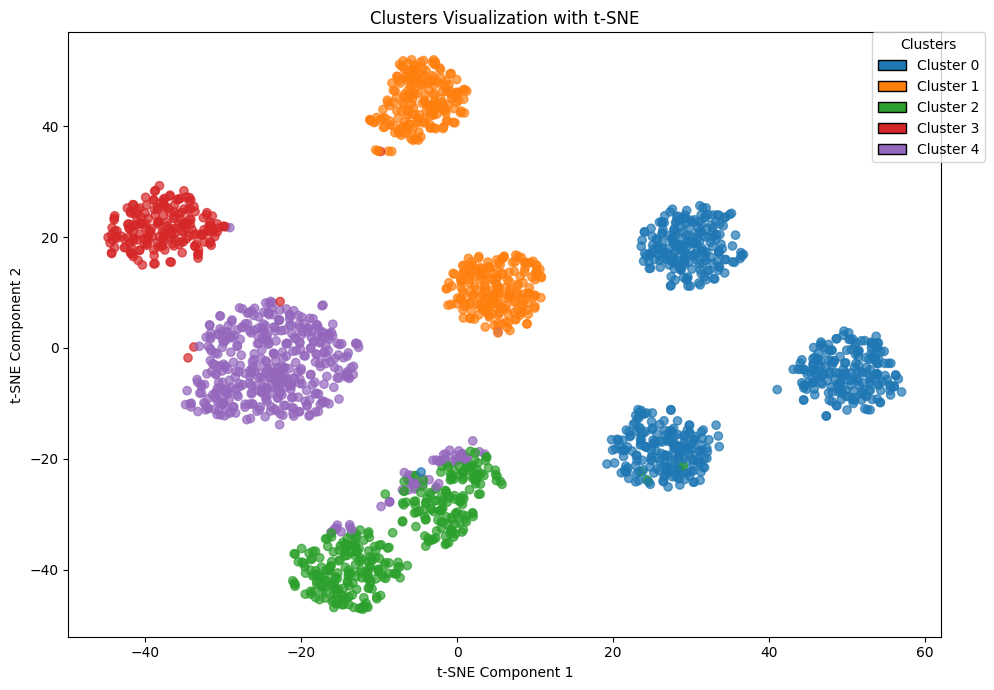

In [26]:
# Drop the 'emotion' column for clustering purposes
data = df.drop(columns=["filename", "emotion", "audio_data", "sr", "processed_audio"])

# Handle any missing values if necessary
data = data.fillna(0)

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply KMeans clustering algorithm
kmeans = KMeans(n_clusters=n_emotions, random_state=99)
kmeans.fit(data_scaled)

# Get the cluster labels
labels = kmeans.labels_

# Evaluate the clustering results using silhouette score
silhouette_avg = silhouette_score(data_scaled, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

#### **Dimensionality Reduction using t-SNE**

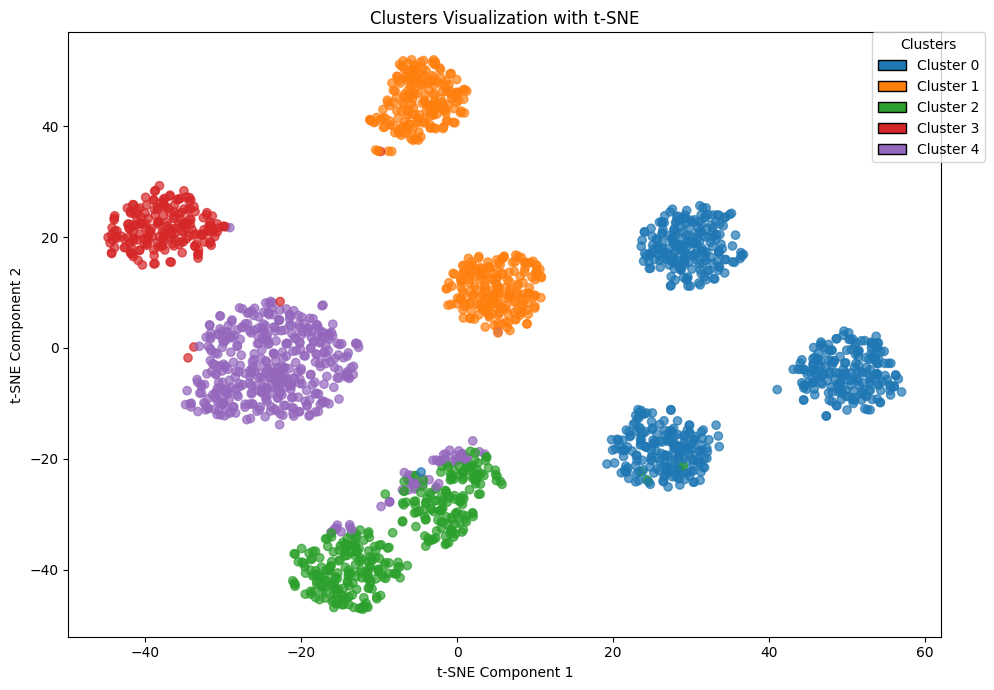

In [50]:
# Reduce the data to two dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=99)
data_tsne = tsne.fit_transform(data_scaled)

cmap = ListedColormap(plt.get_cmap("tab10").colors[:n_emotions])

# Create the scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap=cmap, marker="o", alpha=0.7
)
plt.title("Clusters Visualization with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Create custom legend
# Generate a list of unique cluster labels
unique_labels = np.unique(labels)

# Create a list of Patch objects for the legend
legend_elements = [
    Patch(facecolor=cmap(i), edgecolor="k", label=f"Cluster {i}") for i in unique_labels
]

# Add the legend to the plot
plt.legend(
    handles=legend_elements,
    title="Clusters",
    loc="best",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()